In [91]:
%matplotlib notebook
# Calculation of a magnetic field of a wire
# later I want to to it three dimensional
#https://stackoverflow.com/questions/4969704/python-calculate-the-magnetic-field-of-a-wire-using-biot-savart-law
# Other options:
# https://github.com/grungy/staticbs
#https://someusefulcode.wordpress.com/2012/05/07/a-simple-biot-savart-solver-in-python/

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from pylab import *
from scipy import constants # Constantes Físicas

# Lei de Biot-Savart
$$ d{\bf{B}} = \frac{{\mu _0 }}{{4\pi }}\frac{{Id\ell \times {\bf{\hat r}}}}{{r^2 }}$$

In [111]:
# current in coil, positive goes anti-clockwise in Z-axis
I = -1e3 # 1 kA
#mu0 = 1e-7 ##??
constant = constants.mu_0/(4*np.pi)

a=0.454 # Y coil half-length
b=0.089 # X coil half-length

DLi=0.005 # line integral 'unit' length

# Coil is in Plane XY
# wire vertices position. 
coord = [(b,a), (-b,a), (-b, -a), (b,-a), (b,a)]

coord2 = []

# divide path of the wire in parts of length DLi
parts = 0
for n in range(len(coord)-1):
    lengthx = coord[n+1][0] - coord[n][0]
    lengthy = coord[n+1][1] - coord[n][1]
    length = np.sqrt(lengthx**2 + lengthy**2) / DLi
    for m in range(int(length)):
        coord2.append((coord[n][0]+lengthx/length*m, coord[n][1]+lengthy/length*m))
        parts += 1

# calculate the b-field, return vector
def bfield(x,y,z):
    b = np.zeros((1,3))
    for i in range(parts-1):
        dlx = coord2[i+1][0]-coord2[i][0]
        dly = coord2[i+1][1]-coord2[i][1] 
        dlz = 0
        dl = np.array([dlx,dly,dlz])
        rspace_minus_rwire_x = x - (coord2[i][0]+dlx)
        rspace_minus_rwire_y = y - (coord2[i][1]+dly)
        rspace_minus_rwire_z = z - 0
        rspace_minus_rwire = np.array([rspace_minus_rwire_x, rspace_minus_rwire_y, rspace_minus_rwire_z])
        absr = (rspace_minus_rwire_x**2 + rspace_minus_rwire_y**2 + rspace_minus_rwire_z**2)**0.5
        a = constant * I * np.cross(dl, rspace_minus_rwire) / absr**3
        b += a #(a[0]**2 + a[1]**2 + a[2]**2)**0.5
    return b

In [112]:
xpoints=26
ypoints=26
xwidth = 0.4
ywidth = 0.8
z = 0.01
bmatrix = np.zeros((xpoints,ypoints))
x = np.linspace(0.0, xwidth, xpoints)# (range(xpoints)*xwidth)/xpoints
y = np.linspace(0.0, ywidth, ypoints)#(range(ypoints)*ywidth)/ypoints

for i in range(xpoints):
    for j in range(ypoints):
        vect=bfield(x[i],y[j],z)
#        vect=bfield((i*xwidth)/xpoints,(j*ywidth)/ypoints,z)
        bmatrix[i][j] = np.linalg.norm(vect)


<IPython.core.display.Javascript object>


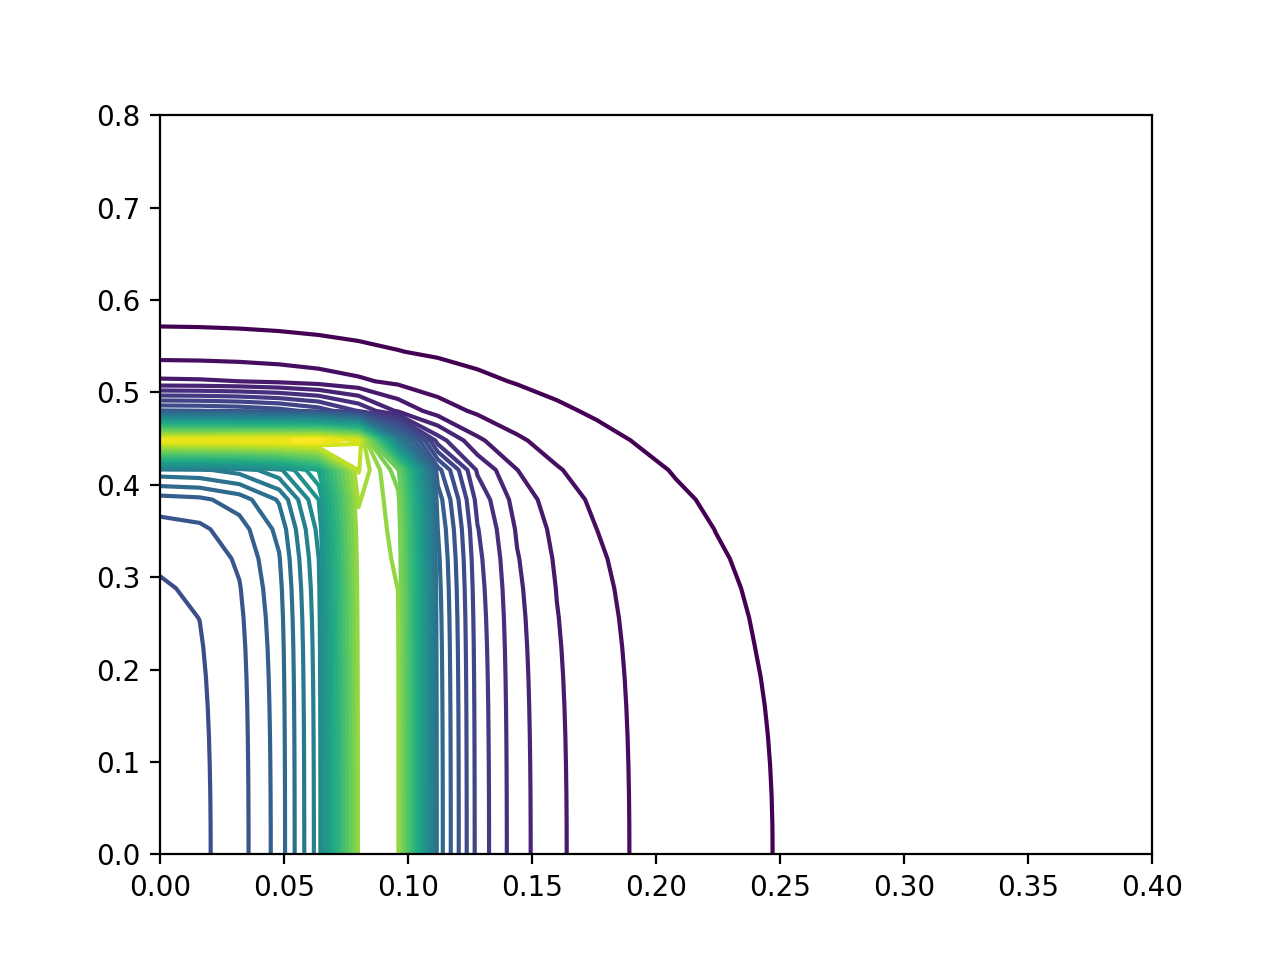

In [113]:
# visualize
plt.figure()
z = bmatrix.T
contour(x,y,z,35)
plt.show()

In [136]:
# Probe is on Plane XZ, on a line rotated Phi from X-axis anti-clockwise
Phi=np.radians(45)
Npoints=20
pointsL=np.linspace(4*b,10*b, Npoints)
#bmatrix = np.zeros((xpoints,ypoints))

In [137]:
Bprobe= np.zeros((Npoints, 1, 3))
Bmag= np.zeros((Npoints, 1))
c, s = np.cos(Phi), np.sin(Phi)
for i in range(Npoints):
        Bprobe[i]=bfield(pointsL[i] * c, 0.0, pointsL[i] * s)
#        Bmag[i]= np.linalg.norm(Bprobe[i])   
Bmag= np.linalg.norm(Bprobe, axis=(1,2))

In [138]:
#Matrix rotation to get B component in Probe refernce axis
rot_matrix=np.array([[c, 0, -s],
                     [0, 1, 0],
                     [s, 0, c]])
Brot  = np.zeros(( Npoints, 1, 3))
#
for i in range(Npoints):
    Brot[i]=np.matmul(Bprobe[i], rot_matrix.T )


<IPython.core.display.Javascript object>


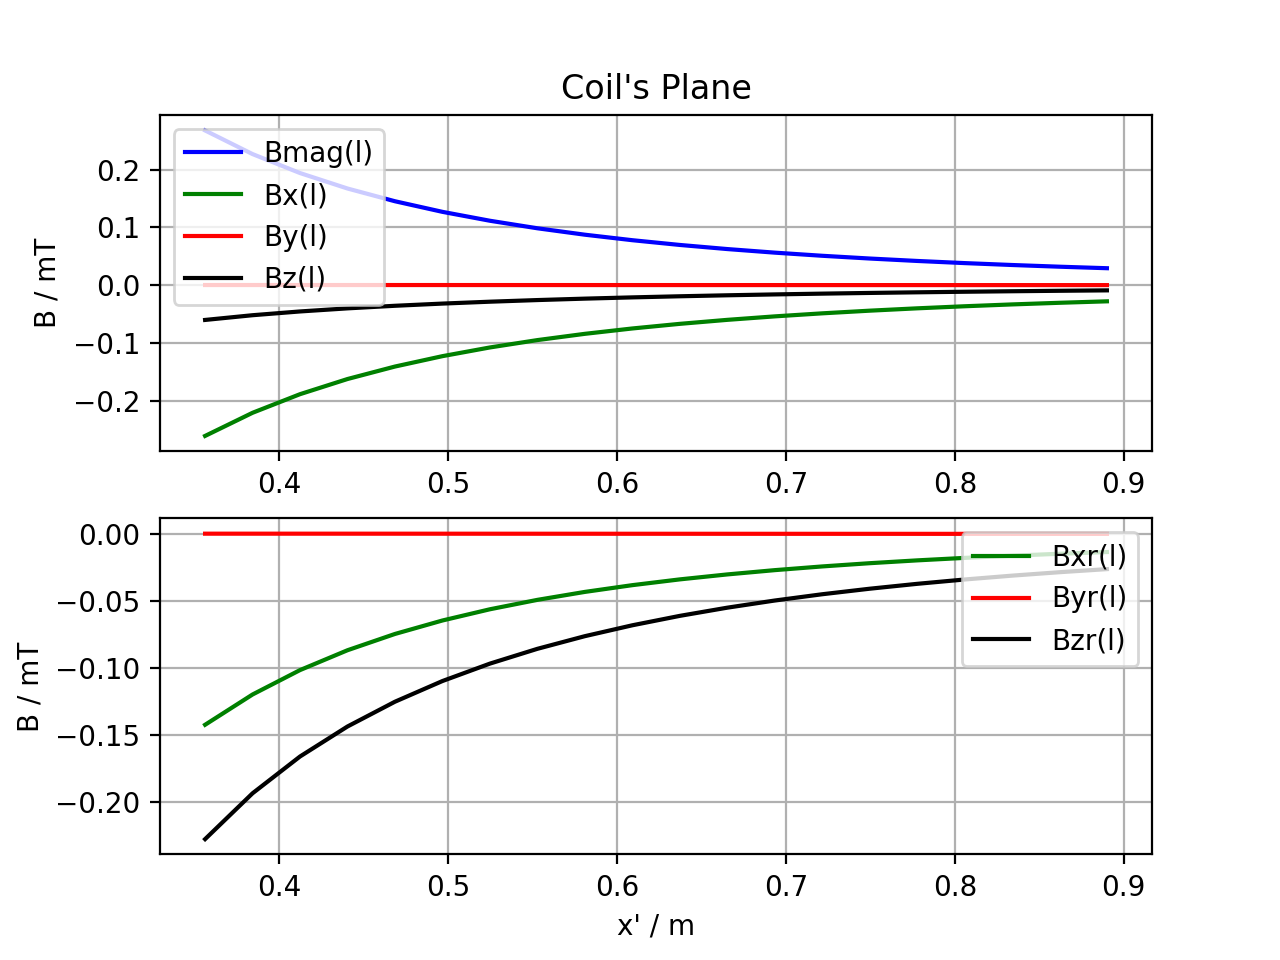

In [139]:
fig = plt.figure()
ax1 = fig.add_subplot(211) # , autoscale_on=False, xlim=(0.8, 2), ylim=(0, 0.1))
#ax2 = fig.add_subplot(212 , autoscale_on=False, xlim=(0.8, 2), ylim=(0, 0.1)) #, autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))
ax2 = fig.add_subplot(212) #, , autoscale_on=False, xlim=(0.8, 2), ylim=(0, 0.1)) #, autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))

ax1.plot(pointsL, 1e3* Bmag, 'b', label='Bmag(l)')
ax1.plot(pointsL, 1e3* Bprobe[:,:,0], 'g', label='Bx(l)')
ax1.plot(pointsL, 1e3* Bprobe[:,:,1], 'r', label='By(l)')
ax1.plot(pointsL, 1e3* Bprobe[:,:,2], 'k', label='Bz(l)')
ax1.set_ylabel('B / mT'), ax2.set_ylabel('B / mT')
ax1.set_title("Coil's Plane") #, ax2.set_title('Sensor Plane')
ax1.grid(), ax2.grid()
ax2.set_xlabel("x' / m")

ax2.plot(pointsL, 1e3* Brot[:,:,0], 'g', label='Bxr(l)')
ax2.plot(pointsL, 1e3* Brot[:,:,1], 'r', label='Byr(l)')
ax2.plot(pointsL, 1e3* Brot[:,:,2], 'k', label='Bzr(l)')
ax1.legend(loc='best'), ax2.legend(loc='upper right')

fig.show()